In [118]:
%matplotlib inline    
import os
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import re
from scipy.stats import ttest_ind


RESULT = "result-raw"
#RESULT = "result"

#path = "c:\\data\\"
#path = "/Users/jeff/temp/dissertation"
#path = "/Users/jeff/dissertation-100runs"
path = "c:\\test\\dissertation-100runs"

filename_read = os.path.join(path,"workload.csv")
df = pd.read_csv(filename_read)

print("Data file contains {} cases".format(len(df)))


Data file contains 7217 cases


# Experiment 1

In [119]:
lookup = {'diff-y0' : 'Difference',
'log-y0' : 'Log',
'poly-y0' : 'Polynomial',
'poly2-y0' : 'Polynomial2',
'pow-y0' : 'Power',
'ratio-y0' : 'Ratio',
'ratio_diff-y0' : 'Ratio Difference',
'ratio_poly-y0' : 'Ratio Polynomial',
'ratio_poly2-y0' : 'Ratio Polynomial2',
'sqrt-y0' : 'Square Root'}


ex1 = df[df.name == 'experiment-1'][['dataset','algorithm','predictors','cycle','result','result-raw']]
f = {'result':['min','mean','std']}
ex1_summary = ex1.groupby(['algorithm']).agg(f)

ex1_summary.columns = [x[1] for x in ex1_summary.columns.values]
ex1_summary.insert(0,'algorithm', ex1_summary.index)
ex1_summary.insert(1, 'name' ,[re.search('\:(.*)\|', x).group(1) for x in ex1_summary.algorithm])
ex1_summary.insert(0, 'set' , [('gp' if 'gp' in x else 'neural') for x in ex1_summary.algorithm])
ex1_summary = ex1_summary[ex1_summary.name.isin(lookup.keys())]
ex1_summary.insert(1, 'expression' ,[lookup[x] for x in ex1_summary.name])
ex1_summary.sort_values(by=['expression'],inplace=True)
ex1_summary.index = range(len(ex1_summary))
ex1_summary.insert(0, 'num', ["{}-{}".format(1,x+1) for x in range(len(ex1_summary))])



In [120]:
# Experiment 1 neural results
ex1_summary_neural = ex1_summary[ex1_summary['set'] == 'neural'][['num','expression','min','mean','std']]
display(ex1_summary_neural)
ex1_summary_neural.to_csv(os.path.join(path,"diss_ex1_neural.csv"),index=False,float_format='%.4f')

,num,expression,min,mean,std
1,1-2,Difference,0.000567,0.315151,0.376694
3,1-4,Log,0.041892,0.476212,0.331350
5,1-6,Polynomial,0.058525,2.499995,1.443175
7,1-8,Polynomial2,0.153444,0.773481,0.392044
9,1-10,Power,0.021631,0.241397,0.092806
11,1-12,Ratio,27.399686,27.470220,0.018127
13,1-14,Ratio Difference,22.973004,22.983069,0.004158
14,1-15,Ratio Polynomial,9.991912,10.230976,0.058621
16,1-17,Ratio Polynomial2,0.028656,0.155777,0.072199
19,1-20,Square Root,0.007459,0.170264,0.097456


In [121]:
# Experiment 1 GP results
ex1_summary_gp = ex1_summary[ex1_summary['set'] == 'gp'][['num','expression','min','mean','std']]
display(ex1_summary_gp)
ex1_summary_gp.to_csv(os.path.join(path,"diss_ex1_gp.csv"),index=False,float_format='%.4f')

,num,expression,min,mean,std
0,1-1,Difference,0.000000e+00,0.062425,0.171248
2,1-3,Log,2.289729e-02,0.200010,0.122143
4,1-5,Polynomial,1.958590e-04,0.943414,0.414078
6,1-7,Polynomial2,2.000133e-01,0.700769,0.251962
8,1-9,Power,0.000000e+00,0.005703,0.034777
10,1-11,Ratio,0.000000e+00,2.426097,6.525352
12,1-13,Ratio Difference,2.290597e+01,22.973158,0.015810
15,1-16,Ratio Polynomial,7.797293e+00,7.836853,0.209149
17,1-18,Ratio Polynomial2,8.117470e-02,0.158659,0.040620
18,1-19,Square Root,1.897332e-18,0.037269,0.037987


# Experiment 2

In [130]:
ex2 = df[df.name == 'experiment-2'][['dataset','algorithm','predictors','cycle','result','result-raw']]
#ex2 = ex2[ex2.dataset != 'feature_eng.csv']

f = {'result-raw':['min','mean','std']}
ex2_summary = ex2.groupby(['algorithm','dataset']).agg(f)

ex2_summary.columns = [x[1] for x in ex2_summary.columns.values]
ex2_summary.insert(0,'algorithm', [x[0] for x in ex2_summary.index])
ex2_summary.insert(0,'dataset', [x[1] for x in ex2_summary.index])
ex2_summary.insert(1, 'name' ,[re.search('(.*)\.', x).group(1) for x in ex2_summary.dataset])
ex2_summary.insert(0, 'set' , [('gp' if 'gp' in x else 'neural') for x in ex2_summary.algorithm])
ex2_summary.index = range(len(ex2_summary))
ex2_summary.sort_values(by=['set','name'],inplace=True)

ex2_summary_neural = ex2_summary[ex2_summary['set'] == 'neural'][['name','min','mean','std']]
ex2_summary_neural.columns = ['name','neural_min','neural_mean','neural_std']
ex2_summary_gp = ex2_summary[ex2_summary['set'] == 'gp'][['name','min','mean','std']]
ex2_summary_gp.columns = ['name','gp_min','gp_mean','gp_std']
ex2_summary = pd.merge(ex2_summary_neural,ex2_summary_gp,how="left",on=['name'])

ex2_summary.insert(0, 'num', ["{}-{}".format(2,x+1) for x in range(len(ex2_summary))])

datasets = ex2_summary.name.values
col_tstat = []
col_pvalue = []

for dataset in datasets:
    filename = dataset + ".csv"
    a = df[ (df.dataset == filename) & (df.name=='experiment-2') & (df.algorithm.str.contains('neural'))][RESULT].tolist()
    b = df[ (df.dataset == filename) & (df.name=='experiment-2') & (df.algorithm.str.contains('gp'))][RESULT].tolist()
    a = [x for x in a if str(x)!='nan']
    b = [x for x in b if str(x)!='nan']
    t = ttest_ind(a, b)
    col_tstat.append(t.statistic)
    col_pvalue.append(t.pvalue)

ex2_summary['t-statistic'] = col_tstat
ex2_summary['p-value'] = col_pvalue

display(ex2_summary)
ex2_summary.to_csv(os.path.join(path,"diss_ex2.csv"),index=False,float_format='%.4f')

,num,name,neural_min,neural_mean,neural_std,gp_min,gp_mean,gp_std,t-statistic,p-value
0,2-1,abalone,2.099181e+00,2.652315,0.446682,2.214939,2.584297e+00,1.446130e-01,1.448699,1.490034e-01
1,2-2,auto-mpg,2.220693e+00,3.337619,1.996870,3.023098,5.428703e+00,9.914787e-01,-9.379307,1.578369e-17
2,2-3,bupa,4.005423e-01,0.455178,0.042088,0.403163,4.745954e-01,2.005960e-02,-4.095390,6.184395e-05
3,2-4,covtype,3.382153e-01,0.399905,0.030958,NaN,NaN,NaN,NaN,NaN
4,2-5,crx,3.061826e-01,0.359279,0.033641,0.316806,3.876705e-01,1.220530e-02,-7.933675,1.538419e-13
5,2-6,forestfires,5.702306e-02,0.060776,0.002385,NaN,NaN,NaN,NaN,NaN
6,2-7,glass,2.742540e-01,0.337689,0.025934,NaN,NaN,NaN,NaN,NaN
7,2-8,heart_cleveland,3.015689e-01,0.337775,0.025806,NaN,NaN,NaN,NaN,NaN
8,2-9,hepatitis,3.973028e-01,0.457608,0.021992,0.392169,4.422143e-01,2.321011e-02,4.802895,3.090703e-06
9,2-10,horse-colic,3.248465e-01,0.365981,0.017882,NaN,NaN,NaN,NaN,NaN


# Experiment 3

In [123]:
ex3 = df[df.name == 'experiment-3'][['dataset','algorithm','predictors','cycle','result','result-raw']]

f = {RESULT:['min','mean','std']}
ex3_summary = ex3.groupby(['dataset']).agg(f)

ex3_summary.columns = [x[1] for x in ex3_summary.columns.values]
ex3_summary.insert(0,'dataset', ex3_summary.index)
ex3_summary.insert(1, 'name' ,[re.search('(.*)\.', x).group(1) for x in ex3_summary.dataset])
ex3_summary.index = range(len(ex3_summary))
ex3_summary.drop('dataset', axis=1, inplace=True)
ex3_summary.columns = ['name','ensemble_min','ensemble_mean','ensemble_std']

ex3_summary = pd.merge(ex3_summary,ex2_summary_neural,how="left",on=['name'])
ex3_summary.drop(['neural_std','neural_min'], axis=1, inplace=True)
ex3_summary.insert(0, 'num', ["{}-{}".format(3,x+1) for x in range(len(ex3_summary))])

datasets = ex3_summary.name.values
col_tstat = []
col_pvalue = []

for dataset in datasets:
    filename = dataset + ".csv"
    a = df[ (df.dataset == filename) & (df.name=='experiment-2') & (df.algorithm.str.contains('neural'))][RESULT].tolist()
    b = df[ (df.dataset == filename) & (df.name=='experiment-3')][RESULT].tolist()
    a = [x for x in a if str(x)!='nan']
    b = [x for x in b if str(x)!='nan']
    t = ttest_ind(a, b)
    col_tstat.append(t.statistic)
    col_pvalue.append(t.pvalue)

ex3_summary['t-statistic'] = col_tstat
ex3_summary['p-value'] = col_pvalue



display(ex3_summary)
ex3_summary.to_csv(os.path.join(path,"diss_ex3.csv"),index=False,float_format='%.4f')

,num,name,ensemble_min,ensemble_mean,ensemble_std,neural_mean,t-statistic,p-value
0,3-1,abalone,2.078315,2.627458,0.473359,2.652315,0.381912,0.702936
1,3-2,auto-mpg,2.189526,3.746307,2.282845,3.337619,-1.347490,0.179362
2,3-3,bupa,0.395708,0.450308,0.029515,0.455178,0.947353,0.344614
3,3-4,crx,0.296556,0.353950,0.026292,0.359279,1.248121,0.213461
4,3-5,hepatitis,0.418459,0.458584,0.020726,0.457608,-0.323032,0.747012
5,3-6,pima-indians-diabetes,0.376184,0.412189,0.026806,0.416390,0.967650,0.334400
6,3-7,wcbreast_wdbc,0.080323,0.097851,0.018390,0.098857,0.367042,0.713980
7,3-8,wcbreast_wpbc,0.265620,0.386851,0.038123,0.381185,-1.023928,0.307119


# Experiment 6

In [124]:
ex6 = df[df.name == 'experiment-6'][['dataset','algorithm','predictors','cycle','result','result-raw']]

f = {RESULT:['min','mean','std']}
ex6_summary = ex6.groupby(['algorithm','dataset']).agg(f)

ex6_summary.columns = [x[1] for x in ex6_summary.columns.values]
ex6_summary.insert(0,'algorithm', [x[0] for x in ex6_summary.index])
ex6_summary.insert(0,'dataset', [x[1] for x in ex6_summary.index])
ex6_summary.insert(1, 'name' ,[re.search('(.*)\.', x).group(1) for x in ex6_summary.dataset])
ex6_summary.index = range(len(ex6_summary))
ex6_summary.drop(['dataset','algorithm'], axis=1, inplace=True)
ex6_summary.columns = ['name','auto_min','auto_mean','auto_std']
ex6_summary = pd.merge(ex6_summary,ex2_summary_neural,how="left",on=['name'])
ex6_summary.drop(['auto_min','auto_std','neural_min','neural_std'], 
                 axis=1, inplace=True)
ex6_summary['diff'] = ex6_summary.auto_mean - ex6_summary.neural_mean
ex6_summary['pct'] = (ex6_summary.auto_mean - ex6_summary.neural_mean) / ex6_summary.neural_mean

ex6_summary.sort_values(by=['name'],inplace=True)
ex6_summary.index = range(len(ex6_summary))
ex6_summary.insert(0, 'num', ["{}-{}".format(6,x+1) for x in range(len(ex6_summary))])
ex6_summary = ex6_summary[['num','name','neural_mean','auto_mean','diff','pct']]


display(ex6_summary)
ex6_summary.to_csv(os.path.join(path,"diss_ex6.csv"),index=False)

,num,name,neural_mean,auto_mean,diff,pct
0,6-1,abalone,2.652315,2.861106,0.208791,0.078720
1,6-2,auto-mpg,3.337619,3.236951,-0.100667,-0.030161
2,6-3,bupa,0.455178,0.449003,-0.006175,-0.013566
3,6-4,covtype,0.399905,0.414058,0.014153,0.035392
4,6-5,crx,0.359279,0.342841,-0.016438,-0.045753
5,6-6,forestfires,0.060776,0.061975,0.001199,0.019726
6,6-7,glass,0.337689,0.330673,-0.007016,-0.020776
7,6-8,heart_cleveland,0.337775,0.348039,0.010264,0.030388
8,6-9,hepatitis,0.457608,0.439215,-0.018393,-0.040193
9,6-10,horse-colic,0.365981,0.379288,0.013307,0.036360


In [125]:
improve_datasets = ex6_summary[ex6_summary.pct<0].name.tolist()

col_num = []
col_names = []
col_tstat = []
col_pvalue = []
col_num = []

for dataset in improve_datasets:
    filename = dataset + ".csv"
    a = df[ (df.dataset == filename) & (df.name=='experiment-2') & (df.algorithm.str.contains('neural'))][RESULT].tolist()
    b = df[ (df.dataset == filename) & (df.name=='experiment-6')][RESULT].tolist()
    t = ttest_ind(a, b)
    col_names.append(dataset)
    col_tstat.append(t.statistic)
    col_pvalue.append(t.pvalue)
    col_num.append( ex6_summary[ex6_summary.name == dataset].num.values[0])
    
ex6_stats = pd.DataFrame({'num':col_num,'name':col_names,'t-statistic':col_tstat,'p-value': col_pvalue},columns=['num','name','t-statistic','p-value'])
display(ex6_stats)
ex6_stats.to_csv(os.path.join(path,"diss_ex6_stat.csv"),index=False)
    

,num,name,t-statistic,p-value
0,6-2,auto-mpg,0.383090,7.020638e-01
1,6-3,bupa,1.190632,2.352234e-01
2,6-5,crx,4.115739,5.660899e-05
3,6-7,glass,1.857998,6.465383e-02
4,6-9,hepatitis,6.679419,2.369695e-10
5,6-11,housing,0.088687,9.294200e-01
6,6-14,soybean_large,3.038647,2.697019e-03
7,6-16,wcbreast_wpbc,1.125605,2.616954e-01
8,6-17,wine,3.030937,2.763675e-03


C:\Users\jeffh\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


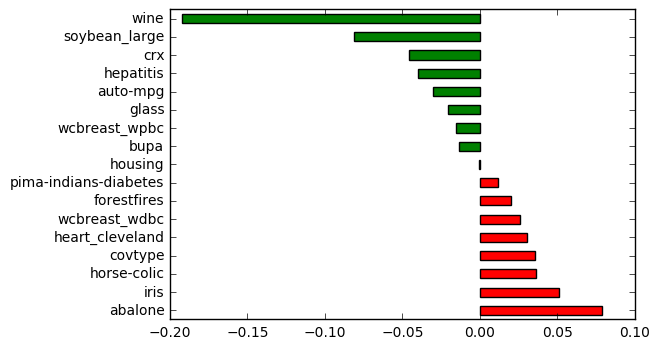

In [129]:
pct = ex6_summary['pct'].tolist()
names = ex6_summary['name'].tolist()
positive = [x>=0 for x in pct]

r = pd.DataFrame( { 'pct': pct, 'positive': positive  }, index = names )
r = r.sort(['pct'], ascending=[0])
r['pct'].plot(kind='barh', color=r['positive'].map({True: 'r', False: 'g'}))
